# Kaggle competition - Outbrain click prediction 

In this notebook, we'll look at some of the datasets that were provided by Outbrain for its Kaggle competition.

The dataset for this challenge contains a sample of users’ page views and clicks, as observed on multiple publisher sites in the United States between 14-June-2016 and 28-June-2016. Each viewed page or clicked recommendation is further accompanied by some semantic attributes of those documents. For full details, see data specifications below.

The dataset contains numerous sets of content recommendations served to a specific user in a specific context. Each context (i.e. a set of recommendations) is given a display_id. In each such set, the user has clicked on at least one recommendation. The identities of the clicked recommendations in the test set are not revealed. Your task is to rank the recommendations in each group by decreasing predicted likelihood of being clicked.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F

/usr/local/bin/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sqlC=SQLContext(sc)

In [3]:
# Data is read from Google Cloud Storage, a distributed filesystem like HDFS.
# Let's Load and join the following datasets: clicks_train, events and promoted_content. 
# load clicks_train dataset
clicks_train_schema = StructType(
                    [   StructField("display_id", IntegerType(), True),
                        StructField("ad_id", IntegerType(), True),
                        StructField("clicked", IntegerType(), True)]
                    )
clicks_train_df = sqlC.read.schema(clicks_train_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("gs://kagglecomp_bucket/clicks_train.csv")


In [4]:
# load "events" dataset
events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )
events_df = sqlC.read.schema(events_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("gs://kagglecomp_bucket/events.csv")

In [5]:
events_df = events_df.sort('display_id')

In [10]:
promoted_content_schema = StructType(
                    [StructField("ad_id", IntegerType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("campaign_id", IntegerType(), True),
                    StructField("advertiser_id", IntegerType(), True)]
                    )
promoted_content_df = sqlC.read.schema(promoted_content_schema).options(header='true', inferschema='false', nullValue='\\N') \
                        .csv("gs://kagglecomp_bucket/promoted_content.csv")

In [11]:
promoted_content_df = promoted_content_df.sort('document_id')

# Joining clicks_train_df, events_df and promoted_content_df

In [12]:
# Add a dummy column to the datasets, this will be useful to identify records source after joining these
promoted_content_df = promoted_content_df.withColumn('dummyPromotedContent', F.lit(1))
clicks_train_df = clicks_train_df.withColumn('dummyClicksTrain', F.lit(1))
events_df = events_df.withColumn('dummyEvents', F.lit(1))

In [9]:
clicks_train_df.show(5)

+----------+------+-------+----------------+
|display_id| ad_id|clicked|dummyClicksTrain|
+----------+------+-------+----------------+
|         1| 42337|      0|               1|
|         1|139684|      0|               1|
|         1|144739|      1|               1|
|         1|156824|      0|               1|
|         1|279295|      0|               1|
+----------+------+-------+----------------+
only showing top 5 rows



In [10]:
events_df.show(5)

+----------+--------------+-----------+---------+--------+------------+-----------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|dummyEvents|
+----------+--------------+-----------+---------+--------+------------+-----------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|          1|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|          1|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|          1|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|          1|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|          1|
+----------+--------------+-----------+---------+--------+------------+-----------+
only showing top 5 rows



In [11]:
promoted_content_df.show(5)

+-----+-----------+-----------+-------------+--------------------+
|ad_id|document_id|campaign_id|advertiser_id|dummyPromotedContent|
+-----+-----------+-----------+-------------+--------------------+
|    1|       6614|          1|            7|                   1|
|    2|     471467|          2|            7|                   1|
|    3|       7692|          3|            7|                   1|
|    4|     471471|          2|            7|                   1|
|    5|     471472|          2|            7|                   1|
+-----+-----------+-----------+-------------+--------------------+
only showing top 5 rows



In [13]:
# We have different document_ids in promoted_content_df compared to events_df dataset. 
# Let's remove document_id from promoted_content_df as we won't need it now.
promoted_content_df = promoted_content_df.select('ad_id', 'campaign_id', 'advertiser_id', 'dummyPromotedContent')


In [13]:
promoted_content_df.show(5)

+------+-----------+-------------+--------------------+
| ad_id|campaign_id|advertiser_id|dummyPromotedContent|
+------+-----------+-------------+--------------------+
|371749|       6051|         1531|                   1|
|371657|       6050|         1531|                   1|
|278853|       1960|           45|                   1|
|470614|      16993|         1310|                   1|
|500762|      16993|         1310|                   1|
+------+-----------+-------------+--------------------+
only showing top 5 rows



In [14]:
# Join clicks_train_df and events_df
df_join = clicks_train_df.alias('clicksTrain').join(events_df.alias('events'), \
                                                                    on=['display_id'], how='inner')

In [28]:
df_join.show()

+----------+------+-------+----------------+--------------+-----------+---------+--------+------------+-----------+
|display_id| ad_id|clicked|dummyClicksTrain|          uuid|document_id|timestamp|platform|geo_location|dummyEvents|
+----------+------+-------+----------------+--------------+-----------+---------+--------+------------+-----------+
|       148| 89351|      1|               1|9adce6a5363308|    1205772|    11202|       2|   US>LA>612|          1|
|       148|152140|      0|               1|9adce6a5363308|    1205772|    11202|       2|   US>LA>612|          1|
|       148|152656|      0|               1|9adce6a5363308|    1205772|    11202|       2|   US>LA>612|          1|
|       148|326768|      0|               1|9adce6a5363308|    1205772|    11202|       2|   US>LA>612|          1|
|       463| 28270|      0|               1|85d999a1dd5483|    1787133|    34492|       1|   US>SD>764|          1|
|       463| 38813|      1|               1|85d999a1dd5483|    1787133| 

In [15]:
# join df_join with promoted content
df_join = df_join.alias('df_join').join(promoted_content_df.alias('promotedContent'), \
                                                                    on=['ad_id'], how='inner')

In [16]:
df_join.columns

['ad_id',
 'display_id',
 'clicked',
 'dummyClicksTrain',
 'uuid',
 'document_id',
 'timestamp',
 'platform',
 'geo_location',
 'dummyEvents',
 'campaign_id',
 'advertiser_id',
 'dummyPromotedContent']

# Distribution of campaign success rate

In [17]:
# Keep only relevant columns to calculate campaigns click rate
df_join_2 = df_join.select('ad_id',
 'display_id',
 'clicked',
 'uuid',
 'document_id',
 'campaign_id',
 'advertiser_id'
 )

In [18]:
df_join_2 = df_join_2.sort('display_id')

In [19]:
# Count number of ads by campaign
ads_by_campaign_df = df_join_2.groupby('campaign_id').count()

In [20]:
ads_by_campaign_df = ads_by_campaign_df.selectExpr("campaign_id as campaign_id", "count as nbr_ads")

In [22]:
ads_by_campaign_df.show(5)

+-----------+-------+
|campaign_id|nbr_ads|
+-----------+-------+
|      25591|    194|
|        471|   4438|
|      11858|  40805|
|      18654|  16275|
|       6658|   5836|
+-----------+-------+
only showing top 5 rows



In [21]:
# Count clicked ads by campaign
clicked_ads_by_campaign_df = df_join_2.filter('clicked = 1').groupBy('campaign_id').count()

In [30]:
clicked_ads_by_campaign_df = clicked_ads_by_campaign_df.selectExpr("campaign_id as campaign_id", "count as nbr_clicked_ads")


In [40]:
clicked_ads_by_campaign_df.show(5)

+-----------+---------------+-------------------------+
|campaign_id|nbr_clicked_ads|dummyClickedAdsByCampaign|
+-----------+---------------+-------------------------+
|      28124|             27|                        1|
|      11858|          10879|                        1|
|      25591|             17|                        1|
|      29054|            183|                        1|
|      18654|           2533|                        1|
+-----------+---------------+-------------------------+
only showing top 5 rows



In [19]:
# 32676 records expected 
ads_by_campaign_df.count()

32676

In [28]:
# 28285 records expected 
clicked_ads_by_campaign_df.count()

28285

In [36]:
# Add dummy columns and join ads_by_campaign_df and clicked_ads_by_campaign_df
ads_by_campaign_df = ads_by_campaign_df.withColumn('dummyAdsByCampaign', F.lit(1))
clicked_ads_by_campaign_df = clicked_ads_by_campaign_df.withColumn('dummyClickedAdsByCampaign', F.lit(1))

In [37]:
Join_ads_clicked_ads_by_campaign = ads_by_campaign_df.alias('ads_by_campaign').join(clicked_ads_by_campaign_df.alias('clicked_ads_by_campaign'), \
                                                                    on=['campaign_id'], how='left')

In [39]:
# Replace null values by zero
Join_ads_clicked_ads_by_campaign = Join_ads_clicked_ads_by_campaign.na.fill({'nbr_clicked_ads': 0})

In [26]:
%time Join_ads_clicked_ads_by_campaign.show()

+-----------+-------+------------------+---------------+-------------------------+
|campaign_id|nbr_ads|dummyAdsByCampaign|nbr_clicked_ads|dummyClickedAdsByCampaign|
+-----------+-------+------------------+---------------+-------------------------+
|        148|    609|                 1|             21|                        1|
|        463|    636|                 1|            176|                        1|
|        471|   4438|                 1|            779|                        1|
|        496|   1941|                 1|            314|                        1|
|        833|    290|                 1|             13|                        1|
|       1088|     33|                 1|              3|                        1|
|       1238|   5084|                 1|           1223|                        1|
|       1342|    149|                 1|             17|                        1|
|       1580|   3467|                 1|            503|                        1|
|   

In [41]:
# For each campaign_id calculate the rate of clicks as the ratio of clicked ads and the number of displayed ads
Join_ads_clicked_ads_by_campaign.registerTempTable("Join_ads_clicked_ads_by_campaign")

In [42]:
Join_ads_clicked_ads_by_campaign = sqlC.sql('SELECT *, nbr_clicked_ads/NULLIF(nbr_ads,0) AS campaign_click_rate FROM Join_ads_clicked_ads_by_campaign')

In [43]:
Join_ads_clicked_ads_by_campaign.columns

['campaign_id',
 'nbr_ads',
 'dummyAdsByCampaign',
 'nbr_clicked_ads',
 'dummyClickedAdsByCampaign',
 'campaign_click_rate']

In [44]:
%time Join_ads_clicked_ads_by_campaign.show()

+-----------+-------+------------------+---------------+-------------------------+--------------------+
|campaign_id|nbr_ads|dummyAdsByCampaign|nbr_clicked_ads|dummyClickedAdsByCampaign| campaign_click_rate|
+-----------+-------+------------------+---------------+-------------------------+--------------------+
|        148|    609|                 1|             21|                        1|0.034482758620689655|
|        463|    636|                 1|            176|                        1| 0.27672955974842767|
|        471|   4438|                 1|            779|                        1| 0.17552951780081116|
|        496|   1941|                 1|            314|                        1| 0.16177228232869656|
|        833|    290|                 1|             13|                        1| 0.04482758620689655|
|       1088|     33|                 1|              3|                        1| 0.09090909090909091|
|       1238|   5084|                 1|           1223|        

In [45]:
# Convert Join_ads_clicked_ads_by_campaign to Pandas dataframe for plotting
Join_ads_clicked_ads_by_campaign_pd = Join_ads_clicked_ads_by_campaign.select('campaign_click_rate').toPandas()

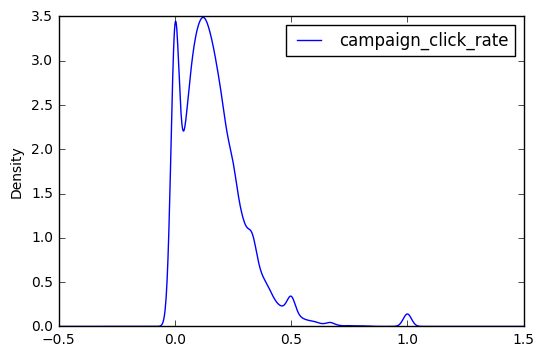

In [48]:
Join_ads_clicked_ads_by_campaign_pd.plot.density()
plt.show()

In [49]:
clicked_ads_by_campaign_dist_df_pd = Join_ads_clicked_ads_by_campaign.select('nbr_clicked_ads').toPandas()

In [55]:
clicked_ads_by_campaign_dist_df_pd = clicked_ads_by_campaign_dist_df_pd['nbr_clicked_ads'].value_counts()

In [68]:
clicked_ads_by_campaign_dist_df_pd.head()

0    4391
1    2273
2    1449
3    1128
4     903
Name: nbr_clicked_ads, dtype: int64

In [65]:
total_nbr_campaigns = len(Join_ads_clicked_ads_by_campaign_pd.index)

In [66]:
total_nbr_campaigns

32676

In [73]:
for i in [2, 5, 10, 25, 50, 100, 200, 500, 1000, 1500, 2000, 3000]:
    Nbr_campaign_with_i_clicked_ads = clicked_ads_by_campaign_dist_df_pd[clicked_ads_by_campaign_dist_df_pd.index < i].sum()
    Pct = round(Nbr_campaign_with_i_clicked_ads/float(total_nbr_campaigns) * 100, 2)
    print('Percentage of campaigns with less than {} clicked ads: {}%'.format(i, Pct))

Percentage of campaigns with less than 2 clicked ads: 20.39%
Percentage of campaigns with less than 5 clicked ads: 31.04%
Percentage of campaigns with less than 10 clicked ads: 40.45%
Percentage of campaigns with less than 25 clicked ads: 53.61%
Percentage of campaigns with less than 50 clicked ads: 62.35%
Percentage of campaigns with less than 100 clicked ads: 70.48%
Percentage of campaigns with less than 200 clicked ads: 77.95%
Percentage of campaigns with less than 500 clicked ads: 86.06%
Percentage of campaigns with less than 1000 clicked ads: 90.81%
Percentage of campaigns with less than 1500 clicked ads: 93.06%
Percentage of campaigns with less than 2000 clicked ads: 94.34%
Percentage of campaigns with less than 3000 clicked ads: 96.0%
